In [33]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os
import statistics
import math

In [1]:
file_path = '/Users/alicemartin/000_Boulot_Polytechnique/07_PhD_thesis/code/SMC-T/output/post_UAI_exp/results_ws155_632020/time_series_multi_synthetic_heads_2_depth_6_dff_24_pos-enc_50_pdrop_0_b_256_target-feat_0_cv_False__particles_1_noise_False_sigma_0.05/inference_results/num-timesteps_4_p_inf_10_N_10_N-est_5000_sigma_0.05_omega_0.3'

### upload numpy arrays (predicted gaussian means and true gaussian mean)

In [24]:
preds_gaussian_means_path = os.path.join(file_path, 'pred_gaussian_means_per_timestep.npy')
true_gaussian_mean_path = os.path.join(file_path, 'true_gaussian_means.npy')
sampling_weights_path = os.path.join(file_path, 'sampling_weights.npy')
sampled_pred_distrib_path = os.path.join(file_path, 'preds_sampled_per_timestep.npy')
true_emp_distrib_path = os.path.join(file_path, 'true_empirical_distrib.npy')

preds_gaussian_means = np.load(preds_gaussian_means_path) # (num_timesteps, B, N, P, 1)
true_gaussian_mean = np.load(true_gaussian_mean_path) # (num_timesteps, B, F)
sampling_weights = np.load(sampling_weights_path)
sampled_pred_distrib = np.load(sampled_pred_distrib_path)
true_emp_distrib = np.load(true_emp_distrib_path)

# take the first feature of the true gaussian mean
true_gaussian_mean = true_gaussian_mean[:,:,0] # (num_timesteps, B)

In [25]:
print('predicted gaussian means', preds_gaussian_means.shape)
print('true_gaussian_mean', true_gaussian_mean.shape)

predicted gaussian means (4, 5000, 10, 10, 1)
true_gaussian_mean (4, 5000)


In [26]:
omega_preds = 0.3
omega_true_distrib = 0.2

### plot function for the predicted and true pdf
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

In [36]:
def compute_mixture_gaussian_pdf(x, pred_means, omega_preds, sampling_weights):
    '''
    x: numpy array of shape (num_samples,)
    pred_means: numpy array of shape (batch_size, num MC samples, num particles, 1)
    omega_preds: scalar for the covariance value. 
    -sampling weights: numpy array of shape (batch_size, num_particle)
    '''
    pdf = np.exp(-(x-pred_means)^2/omega_preds)/ ((2*math.pi)^(1/2)*omega_preds)

In [37]:
omega_preds = 3
true_mean = true_gaussian_mean[0, 0]
x = np.linspace(start=true_mean-5*omega_preds, stop = true_mean+5*omega_preds)
sampling_weight= sampling_weights[0,:]
pred_means = preds_gaussian_means[0, 0, :, :, :]
compute_mixture_gaussian_pdf(x, pred_means, omega_preds, sampling_weight)

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [31]:
def plot_one_timestep(pred_means, true_means, sampling_weights, omega_preds, omega_true_distrib, seed='123'):
    '''
    args:
        -pred_means: numpy array of shape (batch_size, num MC samples, num particles, 1)
        -true_means: numpy array of shape (batch_size)
        -sampling weights: numpy array of shape (batch_size, num_particle)
    '''
    np.random.seed = seed
    N = pred_means.shape[1]
    P = pred_means.shape[2]
    # draw a sample among the samples of the test set:
    batch_size = pred_means.shape[0]
    index = np.random.randint(low=0, high=batch_size)
    pred_means = pred_means[index, :, :, :].reshape(N,P)
    true_mean = true_means[index]
    print('true mean', true_mean)
    sampling_weights = sampling_weights[index, :]
    
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(start=true_mean-5*omega_preds, stop = true_mean+5*omega_preds)
    print('x', x.shape)
    # compute pdf:
    pdf_P = np.zeros(shape=P)
    for p in range(P):
        mean_p = pred_means[:,p]
        list_pdf = [scipy.stats.norm.pdf(x, loc=mean_p[n], scale=omega_preds) for n in range(N)] #TODO: compute manually the function instead. 
        print('number of n pdf', len(list_pdf))
        print('example of pdf', list_pdf[0])
        mean_pdf_N = statistics.mean(list_pdf)
        print('pdf for particle number: {}'.format(mean_pdf_N))
        pdf[p] = mean_pdf_N
    pdf = np.dot(sampling_weights, pdf_P)
    print('final mixture of gaussian', pdf)

true mean 1.3951117
x (50,)
number of n pdf 10
example of pdf [4.20802166e-06 1.15101590e-05 3.01992816e-05 7.60017923e-05
 1.83469125e-04 4.24828925e-04 9.43576467e-04 2.01025919e-03
 4.10808050e-03 8.05263042e-03 1.51407895e-02 2.73068253e-02
 4.72395588e-02 7.83885061e-02 1.24770202e-01 1.90493999e-01
 2.78973951e-01 3.91884369e-01 5.28036767e-01 6.82468040e-01
 8.46081903e-01 1.00613076e+00 1.14764715e+00 1.25566639e+00
 1.31780785e+00 1.32660566e+00 1.28098349e+00 1.18647107e+00
 1.05410217e+00 8.98297512e-01 7.34293389e-01 5.75746057e-01
 4.33016315e-01 3.12384503e-01 2.16165626e-01 1.43481438e-01
 9.13517229e-02 5.57891438e-02 3.26809433e-02 1.83633285e-02
 9.89737802e-03 5.11682831e-03 2.53742647e-03 1.20697429e-03
 5.50699276e-04 2.41014364e-04 1.01177345e-04 4.07413641e-05
 1.57361971e-05 5.83009913e-06]


TypeError: can't convert type 'ndarray' to numerator/denominator

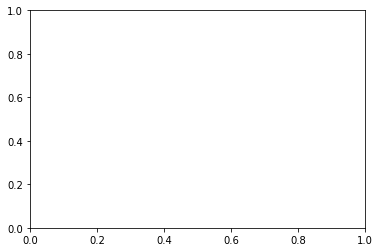

In [32]:
pred_means_t0 = preds_gaussian_means[0, :, :, :]
true_mean_t0 = true_gaussian_mean[0, :]

plot_one_timestep(pred_means=pred_means_t0, true_means=true_mean_t0, sampling_weights=sampling_weights, omega_preds=0.3, 
                  omega_true_distrib=0.2)